In [1]:
import numpy as np
import pandas as pd
import glob
import PIL.Image
import matplotlib.pyplot as plt

PTH='/home/lauh/projects/def-gambsseb/lauh/latent_space/GAN/'
TMP_DIR='/localscratch/lauh.67016558.0'
IMG_SIZE=32
TRAIN_SIZE=5000
RANDOM_SEED=123

In [3]:
def get_z_trgt_proj(folder):
    z_list=[]
    target_list=[]
    proj_list=[]
    img_folder= glob.glob(PTH+'{}/*'.format(folder))
    
    for img_pth in img_folder:
        data= np.load(img_pth+'/latent_vector.npz')
        z= data['latent_vector']
        z=z.reshape((-1,))
        z_list.append(z)
        target_list.append(np.array(PIL.Image.open(img_pth+'/target_image.png'))/255.)
        proj_list.append(np.array(PIL.Image.open(img_pth+'/reconstructed_image.png'))/255.)
    return np.stack(z_list), np.stack(target_list), np.stack(proj_list)

z_member, target_member, proj_member=get_z_trgt_proj('z_member5k2')
z_non_member, target_non_member, proj_non_member=get_z_trgt_proj('z_non_member5k2')

In [3]:
z_member.shape

(2000, 256)

In [4]:
def compute_l2(target, proj):
    l2=[]
    for i in range(len(target)):
        l2.append(np.sqrt(np.sum((target[i]-proj[i])**2)))
    return l2

l2_member= compute_l2(target_member, proj_member)
l2_non_member= compute_l2(target_non_member, proj_non_member)

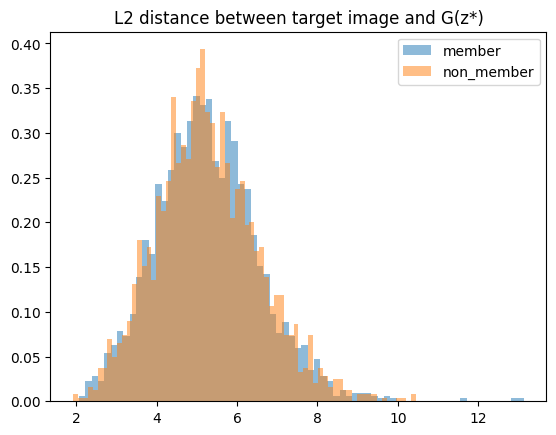

avg l2 reconstruction member 5.266200559862793
avg l2 reconstruction non_member 5.2690902393848775


In [6]:
plt.hist(l2_member, density=True, label='member', alpha=.5, bins=70)
plt.hist(l2_non_member, density=True, label='non_member', alpha=.5, bins=70)
#plt.hist(l2_attack, density=True, label='attack', alpha=.1, bins=10)
plt.title('L2 distance between target image and G(z*)')
plt.legend()
plt.show()

print('avg l2 reconstruction member', np.mean(l2_member))
print('avg l2 reconstruction non_member', np.mean(l2_non_member))

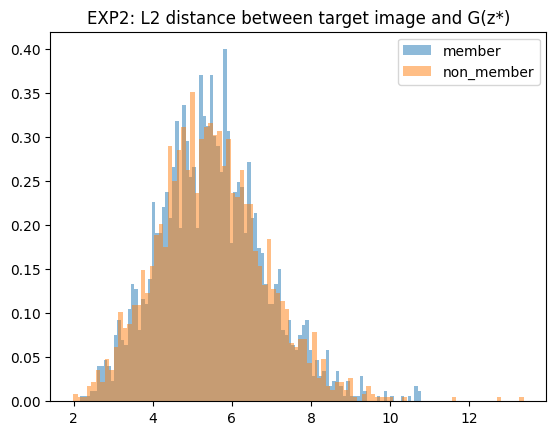

avg l2 reconstruction member 5.504059838271843
avg l2 reconstruction non_member 5.487151232586678


In [7]:
plt.hist(l2_member, density=True, label='member', alpha=.5, bins=100)
plt.hist(l2_non_member, density=True, label='non_member', alpha=.5, bins=100)
#plt.hist(l2_attack, density=True, label='attack', alpha=.1, bins=10)
plt.title('EXP2: L2 distance between target image and G(z*)')
plt.legend()
plt.show()

print('avg l2 reconstruction member', np.mean(l2_member))
print('avg l2 reconstruction non_member', np.mean(l2_non_member))

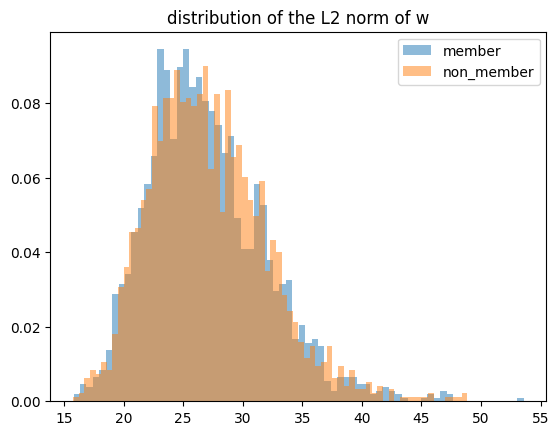

avg l2 norm z member: 27.003063
avg l2 norm z non member: 27.142918
attack on reconstruction 0.55
attack on norm 0.45


In [9]:
#norm_attack=np.linalg.norm(w_attack, axis=1)
norm_member=np.linalg.norm(z_member, axis=1)
norm_non_member=np.linalg.norm(z_non_member, axis=1)

plt.hist(norm_member, density=True, label='member', alpha=.5, bins=70)
plt.hist(norm_non_member, density=True, label='non_member', alpha=.5, bins=70)
#plt.hist(norm_attack, density=True, label='attack', alpha=.1, bins=10)
plt.title('distribution of the L2 norm of w')
plt.legend()
plt.show()

print('avg l2 norm z member:', np.mean(norm_member))
print('avg l2 norm z non member:', np.mean(norm_non_member))

df_member= pd.DataFrame({'reconstruction_l2': l2_member, 'z_l2': norm_member, 'member':[1 for i in range(len(l2_member))]})
df_non_member= pd.DataFrame({'reconstruction_l2': l2_non_member, 'z_l2': norm_non_member, 'member':[0 for i in range(len(l2_non_member))]})
df= pd.concat([df_member, df_non_member], axis =0, ignore_index=True)

threshold= df.reconstruction_l2.quantile(.01)
print('attack on reconstruction', df.loc[df.reconstruction_l2<= threshold,'member'].mean())

threshold= df.z_l2.quantile(.01)
print('attack on norm', df.loc[df.z_l2<= threshold,'member'].mean())

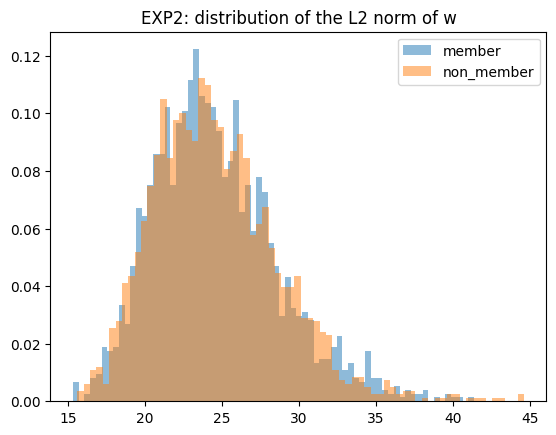

avg l2 norm z member: 24.605236
avg l2 norm z non member: 24.59022
attack on reconstruction 0.45
attack on norm 0.475


In [6]:
#norm_attack=np.linalg.norm(w_attack, axis=1)
norm_member=np.linalg.norm(z_member, axis=1)
norm_non_member=np.linalg.norm(z_non_member, axis=1)

plt.hist(norm_member, density=True, label='member', alpha=.5, bins=70)
plt.hist(norm_non_member, density=True, label='non_member', alpha=.5, bins=70)
#plt.hist(norm_attack, density=True, label='attack', alpha=.1, bins=10)
plt.title('EXP2: distribution of the L2 norm of w')
plt.legend()
plt.show()

print('avg l2 norm z member:', np.mean(norm_member))
print('avg l2 norm z non member:', np.mean(norm_non_member))

df_member= pd.DataFrame({'reconstruction_l2': l2_member, 'z_l2': norm_member, 'member':[1 for i in range(len(l2_member))]})
df_non_member= pd.DataFrame({'reconstruction_l2': l2_non_member, 'z_l2': norm_non_member, 'member':[0 for i in range(len(l2_non_member))]})
df= pd.concat([df_member, df_non_member], axis =0, ignore_index=True)

threshold= df.reconstruction_l2.quantile(.01)
print('attack on reconstruction', df.loc[df.reconstruction_l2<= threshold,'member'].mean())

threshold= df.z_l2.quantile(.01)
print('attack on norm', df.loc[df.z_l2<= threshold,'member'].mean())

In [8]:
import random
import os
random.seed(RANDOM_SEED)
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

print(os.path.join(TMP_DIR, "cifar-10-python.tar.gz"))
full_dataset= datasets.CIFAR10(
            os.path.join(TMP_DIR, "cifar-10-python.tar.gz"),
            train=True,
            download=True,
            transform=transforms.Compose(
                [transforms.Resize(IMG_SIZE), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
            ),
        )

all_indices= [i for i in range(len(full_dataset))]
random.shuffle(all_indices)

training_set= Subset(full_dataset, all_indices[TRAIN_SIZE-2000:TRAIN_SIZE])
non_member_set= Subset(full_dataset, all_indices[TRAIN_SIZE:TRAIN_SIZE+2000])

member_label=[]
non_member_label=[]

for i in range(len(training_set)):
    member_label.append(training_set.__getitem__(i)[1])
for i in range(len(non_member_set)):
    non_member_label.append(non_member_set.__getitem__(i)[1])


/localscratch/lauh.67016558.0/cifar-10-python.tar.gz


0it [00:00, ?it/s]

Extracting /localscratch/lauh.67016558.0/cifar-10-python.tar.gz/cifar-10-python.tar.gz to /localscratch/lauh.67016558.0/cifar-10-python.tar.gz


In [11]:
training_set= Subset(full_dataset, all_indices[TRAIN_SIZE-2000:TRAIN_SIZE])
non_member_set= Subset(full_dataset, all_indices[TRAIN_SIZE:TRAIN_SIZE+2000])

member_label=[]
non_member_label=[]

for i in range(len(training_set)):
    member_label.append(training_set.__getitem__(i)[1])
for i in range(len(non_member_set)):
    non_member_label.append(non_member_set.__getitem__(i)[1])


In [5]:
TRAIN_SIZE

5000

In [4]:
all_indices

[9926,
 35283,
 27382,
 36541,
 23204,
 30508,
 24079,
 48121,
 43668,
 43464,
 14772,
 4994,
 6959,
 23321,
 29370,
 19160,
 32006,
 29728,
 39381,
 21886,
 1380,
 5942,
 27236,
 47325,
 7675,
 21429,
 7908,
 25150,
 21262,
 48345,
 497,
 29693,
 23143,
 8085,
 25213,
 46743,
 28159,
 47734,
 14997,
 24125,
 32876,
 12291,
 7099,
 38653,
 15987,
 5072,
 36689,
 16765,
 35542,
 19516,
 40643,
 32670,
 18632,
 37770,
 46394,
 29368,
 21393,
 9693,
 20328,
 12673,
 12278,
 33373,
 40353,
 44947,
 29862,
 29607,
 18346,
 8968,
 41039,
 46666,
 16469,
 15341,
 8629,
 31785,
 26261,
 26979,
 22134,
 49846,
 3445,
 28212,
 40420,
 46359,
 45190,
 41119,
 44387,
 45647,
 40808,
 30073,
 6842,
 11204,
 46906,
 14126,
 5579,
 6919,
 9239,
 584,
 2405,
 18435,
 39588,
 26062,
 31825,
 33048,
 9437,
 24382,
 29343,
 45678,
 17844,
 22847,
 47849,
 8653,
 20082,
 15014,
 3815,
 20353,
 25477,
 18343,
 48470,
 40350,
 35074,
 31472,
 38283,
 39469,
 23687,
 19578,
 43884,
 716,
 26654,
 33581,
 243

In [8]:
all_indices

[9926,
 35283,
 27382,
 36541,
 23204,
 30508,
 24079,
 48121,
 43668,
 43464,
 14772,
 4994,
 6959,
 23321,
 29370,
 19160,
 32006,
 29728,
 39381,
 21886,
 1380,
 5942,
 27236,
 47325,
 7675,
 21429,
 7908,
 25150,
 21262,
 48345,
 497,
 29693,
 23143,
 8085,
 25213,
 46743,
 28159,
 47734,
 14997,
 24125,
 32876,
 12291,
 7099,
 38653,
 15987,
 5072,
 36689,
 16765,
 35542,
 19516,
 40643,
 32670,
 18632,
 37770,
 46394,
 29368,
 21393,
 9693,
 20328,
 12673,
 12278,
 33373,
 40353,
 44947,
 29862,
 29607,
 18346,
 8968,
 41039,
 46666,
 16469,
 15341,
 8629,
 31785,
 26261,
 26979,
 22134,
 49846,
 3445,
 28212,
 40420,
 46359,
 45190,
 41119,
 44387,
 45647,
 40808,
 30073,
 6842,
 11204,
 46906,
 14126,
 5579,
 6919,
 9239,
 584,
 2405,
 18435,
 39588,
 26062,
 31825,
 33048,
 9437,
 24382,
 29343,
 45678,
 17844,
 22847,
 47849,
 8653,
 20082,
 15014,
 3815,
 20353,
 25477,
 18343,
 48470,
 40350,
 35074,
 31472,
 38283,
 39469,
 23687,
 19578,
 43884,
 716,
 26654,
 33581,
 243

In [ ]:
len(non_member_label)

In [10]:
from wgan import *
gan= WACGAN_GP(name= 'WGAN_GP2')
gan.load_model()


WGAN_GradientPenalty init model.


In [52]:
"""

import time
def compute_image_stability(z_list, label, generator, noise_level=.5):
    l2_diff=[]
    for i in range(len(z_list)):
        #t= time.time()
        c=label[:i+1]
        print(c)
        z= torch.Tensor(z_list[:i+1]).reshape((2,256,1,1))
        target = generator(z.cuda(), c)
        target = target.mul(0.5).add(0.5)
        #PIL.Image.fromarray(synth_image, 'RGB')
        l2_diff_img=[]
        for _ in range(30):
            noise= torch.zeros((1,256,1,1)).normal_(0,noise_level)
            z_noise= z + noise
            synth_image= generator(z_noise.cuda(), torch.tensor([0]).reshape(1,1).cuda())
            synth_image = synth_image.mul(0.5).add(0.5)
            l2= np.sqrt(np.sum((target-synth_image)**2))
            l2_diff_img.append(l2)
        l2_diff.append(np.mean(l2_diff_img))
        #print('processing one w in:',time.time()-t)
    return l2_diff
            
"""


In [11]:
def compute_image_stability(generator, latent_vectors, labels, std=0.5, num_noisy_vectors=30):
    generator.eval()
    device = next(generator.parameters()).device
    latent_vectors = torch.tensor(latent_vectors).to(device).unsqueeze(-1).unsqueeze(-1)
    labels = torch.tensor(labels).to(device)

    # Generate the original projected images
    with torch.no_grad():
        original_images = generator(latent_vectors, labels)
    original_images= original_images.cpu()
    torch.cuda.empty_cache()
    avg_l2_distances = []
    for i, (z, label) in enumerate(zip(latent_vectors, labels)):
        # Generate the noisy latent vectors
        #print(z.shape)
        noise = torch.randn(num_noisy_vectors, 256, 1, 1).to(device) * std
        noisy_latent_vectors = z + noise

        # Repeat the label to match the number of noisy vectors
        repeated_label = label.repeat(num_noisy_vectors)#.unsqueeze(1)
        # Generate images from the noisy latent vectors
        with torch.no_grad():
            noisy_images = generator(noisy_latent_vectors, repeated_label)
        noisy_images=noisy_images.cpu()
        
        # Compute the L2 distance between the original and noisy images
        l2_distances = torch.sqrt(torch.nn.functional.mse_loss(original_images[i].expand_as(noisy_images), noisy_images, reduction='none'))
        l2_distances = torch.mean(l2_distances, dim=(1, 2, 3))

        # Compute the average L2 distance for the current latent vector
        avg_l2_distance = torch.mean(l2_distances)
        avg_l2_distances.append(avg_l2_distance)
        torch.cuda.empty_cache()

    return torch.stack(avg_l2_distances).detach().cpu().numpy()


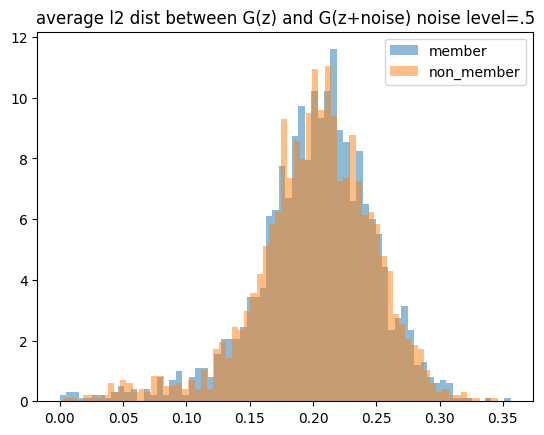

10% 0.4975
1% 0.475


In [14]:
stability_member= compute_image_stability(gan.G,z_member, member_label)
stability_non_member= compute_image_stability(gan.G,z_non_member, non_member_label)

plt.hist(stability_member, density=True, label='member', alpha=.5, bins=70)
plt.hist(stability_non_member, density=True, label='non_member', alpha=.5, bins=70)
plt.title('average l2 dist between G(z) and G(z+noise) noise level=.5')
plt.legend()
plt.show()

df_member= pd.DataFrame({'stability': stability_member, 'member':[1 for i in range(len(stability_member))]})
df_non_member= pd.DataFrame({'stability': stability_non_member, 'member':[0 for i in range(len(stability_non_member))]})
df= pd.concat([df_member, df_non_member], axis =0, ignore_index=True)
threshold= df.stability.quantile(.1)
print('10%', df.loc[df.stability<= threshold,'member'].mean())
threshold= df.stability.quantile(.01)
print('1%', df.loc[df.stability<= threshold,'member'].mean())

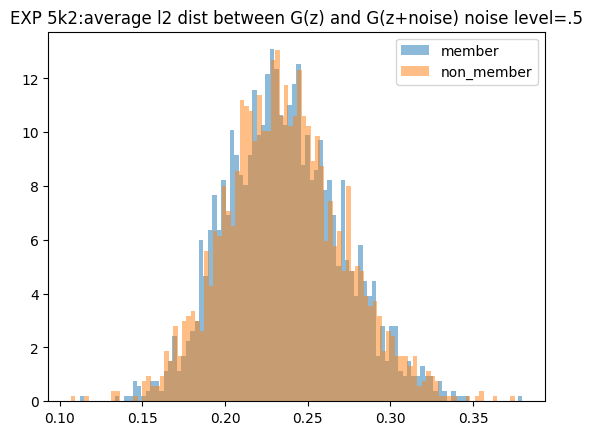

10% 0.505
1% 0.5


In [13]:
#stability_member= compute_image_stability(gan.G,z_member, member_label)
#stability_non_member= compute_image_stability(gan.G,z_non_member, non_member_label)

plt.hist(stability_member, density=True, label='member', alpha=.5, bins=100)
plt.hist(stability_non_member, density=True, label='non_member', alpha=.5, bins=100)
plt.title('EXP 5k2:average l2 dist between G(z) and G(z+noise) noise level=.5')
plt.legend()
plt.show()

df_member= pd.DataFrame({'stability': stability_member, 'member':[1 for i in range(len(stability_member))]})
df_non_member= pd.DataFrame({'stability': stability_non_member, 'member':[0 for i in range(len(stability_non_member))]})
df= pd.concat([df_member, df_non_member], axis =0, ignore_index=True)
threshold= df.stability.quantile(.1)
print('10%', df.loc[df.stability<= threshold,'member'].mean())
threshold= df.stability.quantile(.01)
print('1%', df.loc[df.stability<= threshold,'member'].mean())

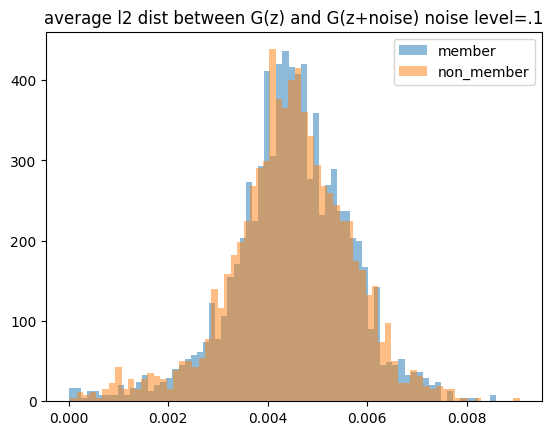

10% 0.4825
1% 0.5


In [26]:
stability_member= compute_image_stability(gan.G,z_member, member_label, std=.1)
stability_non_member= compute_image_stability(gan.G,z_non_member, non_member_label, std=.1)

plt.hist(stability_member, density=True, label='member', alpha=.5, bins=70)
plt.hist(stability_non_member, density=True, label='non_member', alpha=.5, bins=70)
plt.title('average l2 dist between G(z) and G(z+noise) noise level=.1')
plt.legend()
plt.show()

df_member= pd.DataFrame({'stability': stability_member, 'member':[1 for i in range(len(stability_member))]})
df_non_member= pd.DataFrame({'stability': stability_non_member, 'member':[0 for i in range(len(stability_non_member))]})
df= pd.concat([df_member, df_non_member], axis =0, ignore_index=True)
threshold= df.stability.quantile(.1)
print('10%', df.loc[df.stability<= threshold,'member'].mean())
threshold= df.stability.quantile(.01)
print('1%', df.loc[df.stability<= threshold,'member'].mean())

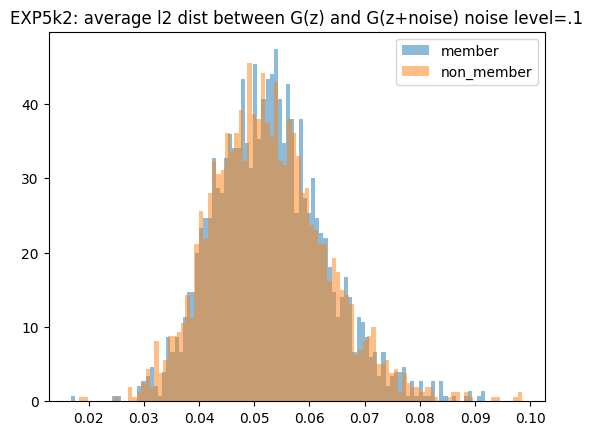

10% 0.4675
1% 0.45


In [15]:
stability_member= compute_image_stability(gan.G,z_member, member_label, std=.1)
stability_non_member= compute_image_stability(gan.G,z_non_member, non_member_label, std=.1)

plt.hist(stability_member, density=True, label='member', alpha=.5, bins=100)
plt.hist(stability_non_member, density=True, label='non_member', alpha=.5, bins=100)
plt.title('EXP5k2: average l2 dist between G(z) and G(z+noise) noise level=.1')
plt.legend()
plt.show()

df_member= pd.DataFrame({'stability': stability_member, 'member':[1 for i in range(len(stability_member))]})
df_non_member= pd.DataFrame({'stability': stability_non_member, 'member':[0 for i in range(len(stability_non_member))]})
df= pd.concat([df_member, df_non_member], axis =0, ignore_index=True)
threshold= df.stability.quantile(.1)
print('10%', df.loc[df.stability<= threshold,'member'].mean())
threshold= df.stability.quantile(.01)
print('1%', df.loc[df.stability<= threshold,'member'].mean())

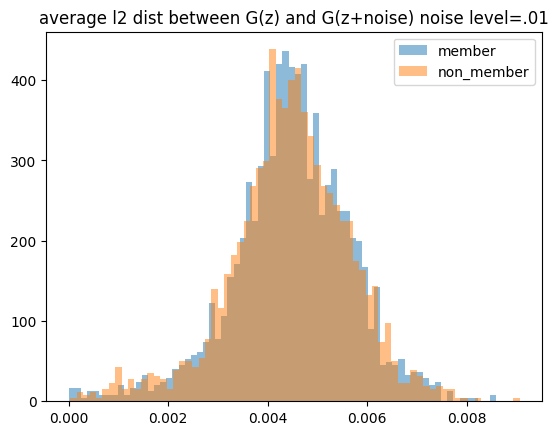

10% 0.4825
1% 0.5


In [25]:
stability_member= compute_image_stability(gan.G,z_member, member_label, std=.01)
stability_non_member= compute_image_stability(gan.G,z_non_member, non_member_label, std=.01)

plt.hist(stability_member, density=True, label='member', alpha=.5, bins=70)
plt.hist(stability_non_member, density=True, label='non_member', alpha=.5, bins=70)
plt.title('average l2 dist between G(z) and G(z+noise) noise level=.01')
plt.legend()
plt.show()

df_member= pd.DataFrame({'stability': stability_member, 'member':[1 for i in range(len(stability_member))]})
df_non_member= pd.DataFrame({'stability': stability_non_member, 'member':[0 for i in range(len(stability_non_member))]})
df= pd.concat([df_member, df_non_member], axis =0, ignore_index=True)
threshold= df.stability.quantile(.1)
print('10%', df.loc[df.stability<= threshold,'member'].mean())
threshold= df.stability.quantile(.01)
print('1%', df.loc[df.stability<= threshold,'member'].mean())

In [ ]:
stability_member= compute_image_stability(gan.G,z_member, member_label, std=.01)
stability_non_member= compute_image_stability(gan.G,z_non_member, non_member_label, std=.01)

plt.hist(stability_member, density=True, label='member', alpha=.5, bins=70)
plt.hist(stability_non_member, density=True, label='non_member', alpha=.5, bins=70)
plt.title('EXP5k2: average l2 dist between G(z) and G(z+noise) noise level=.01')
plt.legend()
plt.show()

df_member= pd.DataFrame({'stability': stability_member, 'member':[1 for i in range(len(stability_member))]})
df_non_member= pd.DataFrame({'stability': stability_non_member, 'member':[0 for i in range(len(stability_non_member))]})
df= pd.concat([df_member, df_non_member], axis =0, ignore_index=True)
threshold= df.stability.quantile(.1)
print('10%', df.loc[df.stability<= threshold,'member'].mean())
threshold= df.stability.quantile(.01)
print('1%', df.loc[df.stability<= threshold,'member'].mean())

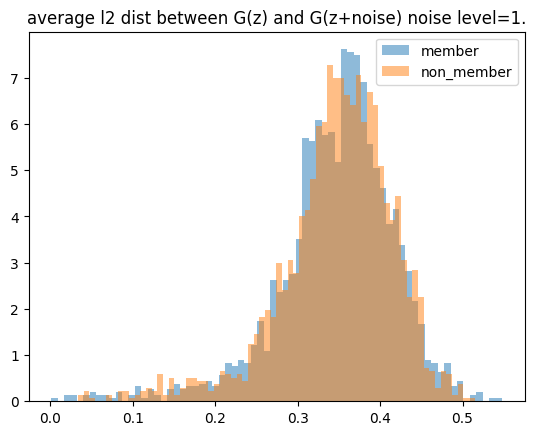

10% 0.4925
1% 0.575


In [27]:
stability_member= compute_image_stability(gan.G,z_member, member_label, std=1.)
stability_non_member= compute_image_stability(gan.G,z_non_member, non_member_label, std=1.)

plt.hist(stability_member, density=True, label='member', alpha=.5, bins=70)
plt.hist(stability_non_member, density=True, label='non_member', alpha=.5, bins=70)
plt.title('average l2 dist between G(z) and G(z+noise) noise level=1.')
plt.legend()
plt.show()

df_member= pd.DataFrame({'stability': stability_member, 'member':[1 for i in range(len(stability_member))]})
df_non_member= pd.DataFrame({'stability': stability_non_member, 'member':[0 for i in range(len(stability_non_member))]})
df= pd.concat([df_member, df_non_member], axis =0, ignore_index=True)
threshold= df.stability.quantile(.1)
print('10%', df.loc[df.stability<= threshold,'member'].mean())
threshold= df.stability.quantile(.01)
print('1%', df.loc[df.stability<= threshold,'member'].mean())

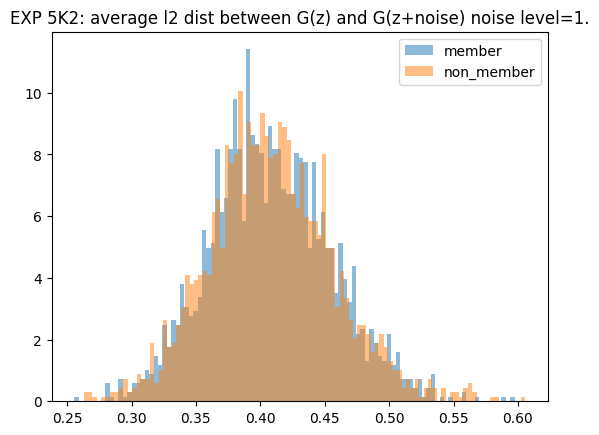

10% 0.49
1% 0.45


In [14]:
stability_member= compute_image_stability(gan.G,z_member, member_label, std=1.)
stability_non_member= compute_image_stability(gan.G,z_non_member, non_member_label, std=1.)

plt.hist(stability_member, density=True, label='member', alpha=.5, bins=100)
plt.hist(stability_non_member, density=True, label='non_member', alpha=.5, bins=100)
plt.title('EXP 5K2: average l2 dist between G(z) and G(z+noise) noise level=1.')
plt.legend()
plt.show()

df_member= pd.DataFrame({'stability': stability_member, 'member':[1 for i in range(len(stability_member))]})
df_non_member= pd.DataFrame({'stability': stability_non_member, 'member':[0 for i in range(len(stability_non_member))]})
df= pd.concat([df_member, df_non_member], axis =0, ignore_index=True)
threshold= df.stability.quantile(.1)
print('10%', df.loc[df.stability<= threshold,'member'].mean())
threshold= df.stability.quantile(.01)
print('1%', df.loc[df.stability<= threshold,'member'].mean())

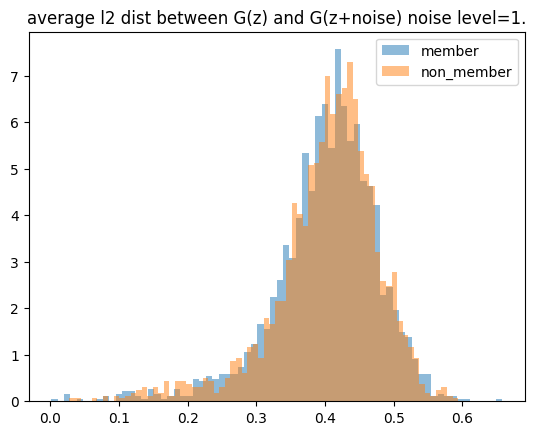

10% 0.5025
1% 0.525


In [28]:
stability_member= compute_image_stability(gan.G,z_member, member_label, std=1.25)
stability_non_member= compute_image_stability(gan.G,z_non_member, non_member_label, std=1.25)

plt.hist(stability_member, density=True, label='member', alpha=.5, bins=70)
plt.hist(stability_non_member, density=True, label='non_member', alpha=.5, bins=70)
plt.title('average l2 dist between G(z) and G(z+noise) noise level=1.')
plt.legend()
plt.show()

df_member= pd.DataFrame({'stability': stability_member, 'member':[1 for i in range(len(stability_member))]})
df_non_member= pd.DataFrame({'stability': stability_non_member, 'member':[0 for i in range(len(stability_non_member))]})
df= pd.concat([df_member, df_non_member], axis =0, ignore_index=True)
threshold= df.stability.quantile(.1)
print('10%', df.loc[df.stability<= threshold,'member'].mean())
threshold= df.stability.quantile(.01)
print('1%', df.loc[df.stability<= threshold,'member'].mean())

In [19]:
4000*0.001

4.0